In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
from model import *
from data import *
from analysis import *

In [3]:
from scipy.interpolate import CubicSpline

In [4]:
oiii = for_oiii()
oiii_ = oiii[oiii["loglbol"] > 46]
oiii_res = np.loadtxt("../output/oiii.res")

cond_oiii = (oiii_res[:,3] > -0.5) & (oiii_res[:,-2] < 50)
oiii_ = oiii_[cond_oiii]
oiii_res = oiii_res[cond_oiii]

initial: 105783
select redshift: 19083
select wise: 15666


In [5]:
x_cigale = Table.read("/Users/wul/Desktop/out/results.fits")

In [6]:
import wise
import jhk
import ugriz

In [69]:
def analysis(i):
    data = oiii_[i]
    flux_ugriz, _ = ugriz.mag_to_flux(data["ugriz_dered"], data["ugriz_err"])
    flux_jhk, _ = jhk.mag_to_flux(data["jhk"], data["jhk_err"])
    flux_wise, _ = wise.mag_to_flux(data["wise1234"], data["wise1234_err"])

    flux = np.concatenate((flux_ugriz, flux_jhk, flux_wise))
    wav = np.concatenate((ugriz.wavelength, jhk.wavelength, wise.wavelength))
    mod = x_cigale[i]['best.sdss.up', 'best.sdss.gp', 'best.sdss.rp', 'best.sdss.ip', 'best.sdss.zp',
                      'best.2mass.J', 'best.2mass.H', 'best.2mass.Ks',
                      'best.WISE1', 'best.WISE2', 'best.WISE3', 'best.WISE4']
    spine = CubicSpline(wav, [np.log10(flux[i]) - np.log10(mod[i]) for i in range(len(mod))])

    zp1 = data["z_hw"] + 1
    tb = Table.read(f"/Users/wul/Desktop/out/{data['sdss_name']}_best_model.fits")
    wavelength = tb["wavelength"] * 1e-3 / zp1
    dust = tb["agn.SKIRTOR2016_dust"] * zp1

    cond = (wavelength > 0.9) & (wavelength < 12.5)

    func0 = interp1d(wavelength[cond], np.log10(dust[cond]), kind='cubic')
    func1 = interp1d(wavelength[cond], np.log10(dust[cond]) + spine(wavelength[cond] * zp1), kind='cubic')

    return [ func0(np.linspace(1, 12)) - np.log10(x_cigale[i]['best.agn.luminosity'])
           , func1(np.linspace(1, 12)) - np.log10(x_cigale[i]['best.agn.luminosity'])
    ]

In [70]:
oiii_ans_x = np.array([analysis(i) for i in range(len(oiii_))])

In [106]:
oiii_cors_x0 = [parcor([np.log10(oiii_["ew_oiii_5007"]), oiii_ans_x[:,0,i], np.log10(x_cigale['best.agn.luminosity']), oiii_["logbh_hb_vp06"]])[0,1]
for i in range(50)]

oiii_cors_x1 = [parcor([np.log10(oiii_["ew_oiii_5007"]), oiii_ans_x[:,1,i], np.log10(x_cigale['best.agn.luminosity']), oiii_["logbh_hb_vp06"]])[0,1]
for i in range(50)]

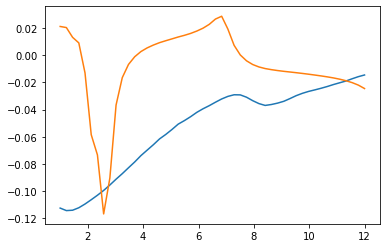

In [107]:
x = np.linspace(1,12)
plt.plot(x, oiii_cors_x0)
plt.plot(x, oiii_cors_x1)

In [73]:
def analysis_spine(i):
    s = oiii_[i]
    rsr, wavelength, lum, lum_unc = prepare_data(s)
    spine = CubicSpline(wavelength, lum)
    return np.log10(spine(np.linspace(1, 12))) - s["loglbol"]

In [74]:
oiii_ans_s = np.array([analysis_spine(i) for i in range(len(oiii_))])

In [103]:
oiii_cors_s = [parcor([np.log10(oiii_["ew_oiii_5007"]), oiii_ans_s[:,i], oiii_["loglbol"], oiii_["logbh_hb_vp06"]])[0,1]
for i in range(50)]

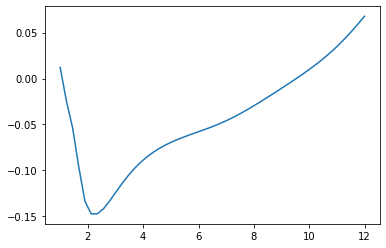

In [104]:
x = np.linspace(1,12)
plt.plot(x, oiii_cors_s)

In [99]:
def analysis_spine_(i):
    s = oiii_[i]
    rsr, wavelength, lum, lum_unc = prepare_data(s)
    spine = CubicSpline(wavelength, lum)
    return spine

In [100]:
oiii_ans_s_ = np.array([np.log10(analysis_spine_(i)(np.linspace(1,12)))  for i in range(len(oiii_))])
oiii_loglbol_s_ = np.array([np.log10(analysis_spine_(i)(0.3)) for i in range(len(oiii_))])

In [101]:
oiii_cors_s_ = [parcor([np.log10(oiii_["ew_oiii_5007"]), oiii_ans_s_[:, i] - oiii_loglbol_s_, oiii_loglbol_s_, oiii_["logbh_hb_vp06"]])[0,1]
for i in range(50)]

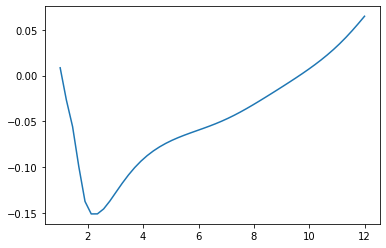

In [102]:
x = np.linspace(1,12)
plt.plot(x, oiii_cors_s_)

In [109]:
tmp = [np.corrcoef([np.log10(oiii_["ew_oiii_5007"]), oiii_ans_s_[:, i] - oiii_loglbol_s_])[0,1]
for i in range(50)]

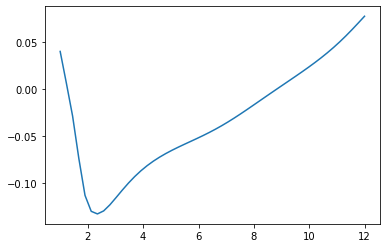

In [110]:
x = np.linspace(1,12)
plt.plot(x, tmp)

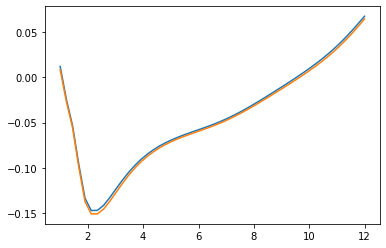

In [105]:
x = np.linspace(1,12)
plt.plot(x, oiii_cors_s)
plt.plot(x, oiii_cors_s_)

In [ ]:
def spline_chi2(i):
    s = oiii_[i]
    rsr, wavelength, lum, lum_unc = prepare_data(s)